In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from torch_geometric.nn import HeteroConv, SAGEConv


df = pd.read_csv('../Datasets/processed_data.csv')
df_advertiser = pd.read_csv('../Datasets/advertiser_embeddings.csv')
df_keywords = pd.read_csv('../Datasets/keyword_embeddings.csv')
df_search_tags = pd.read_csv('../Datasets/search_tag_embeddings.csv')



In [3]:
# Concatenate df_keywords and df_search_tags with the main df along the columns
df = pd.concat([df, df_keywords, df_search_tags], axis=1)

print(df.shape)  # Verify the shape to ensure the merge is correct

(69200, 147)


In [4]:

# Merge embeddings with the main dataset (df) based on advertiser name
df = df.merge(df_advertiser, on="advertiser_name", how="left")

In [5]:
# Define the indices to drop
rows_to_remove = [69130, 69131, 69132, 69133, 69134, 69135]

# Drop the rows
df = df.drop(index=rows_to_remove, errors='ignore')

In [6]:
# The corresponding click values for each record
click_values = torch.tensor(df['clicks'].values, dtype=torch.float)
click_values = click_values.view(-1).float()

# Ensure shapes are appropriate
print(f"clicks shape: {click_values.shape}")

clicks shape: torch.Size([69194])


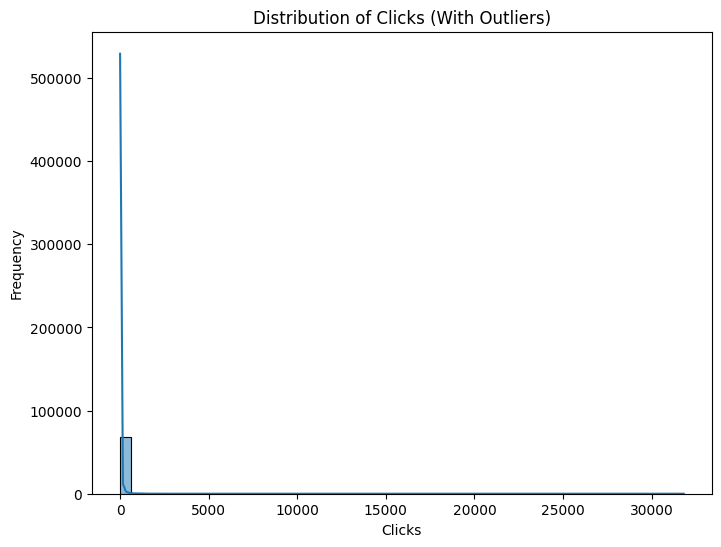

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.histplot(click_values, bins=50, kde=True)
plt.title('Distribution of Clicks (With Outliers)')
plt.xlabel('Clicks')
plt.ylabel('Frequency')
plt.show()


In [8]:
import pandas as pd

# Convert to a Pandas Series for easier analysis
click_series = pd.Series(click_values.numpy())

# Descriptive statistics
print(click_series.describe())

# Skewness and Kurtosis
print(f"Skewness: {click_series.skew():.2f}")
print(f"Kurtosis: {click_series.kurt():.2f}")

count    69194.000000
mean        33.410976
std        266.574402
min          2.000000
25%          5.000000
50%          8.000000
75%         11.000000
max      31807.000000
dtype: float64
Skewness: 62.25
Kurtosis: 5790.96


In [9]:
import numpy as np

# Calculate the 95th percentile threshold
threshold = np.percentile(click_values, 95)
print(f"95th Percentile Threshold: {threshold}")

# Filter out the outliers
click_values_filtered = click_values[click_values <= threshold]

# Check the new distribution
print(f"New Max Value: {click_values_filtered.max()}")
print(f"New Shape: {click_values_filtered.shape}")


95th Percentile Threshold: 118.0
New Max Value: 118.0
New Shape: torch.Size([65749])


In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
click_values_normalized = scaler.fit_transform(click_values_filtered.reshape(-1, 1))

print(f"Normalized Click Values (Min-Max): {click_values_normalized.flatten()[:10]}")


Normalized Click Values (Min-Max): [0.05172414 0.36206897 0.25862069 0.39655172 0.15517241 0.07758621
 0.13793103 0.0862069  0.02586207 0.05172414]


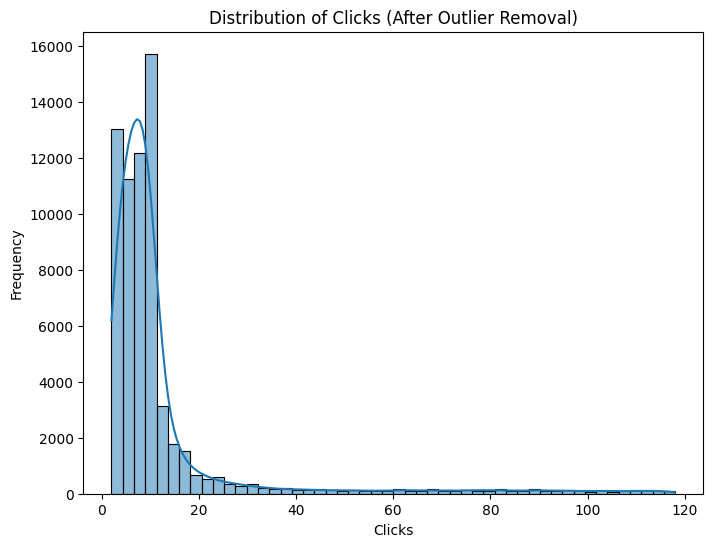

In [11]:
plt.figure(figsize=(8, 6))
sns.histplot(click_values_filtered, bins=50, kde=True)
plt.title('Distribution of Clicks (After Outlier Removal)')
plt.xlabel('Clicks')
plt.ylabel('Frequency')
plt.show()


In [12]:
# Keep only the rows where clicks are below the threshold
df_filtered = df[df['clicks'] <= threshold]
print(f"Filtered Dataset Shape: {df_filtered.shape}")


Filtered Dataset Shape: (65749, 197)


In [13]:
# import numpy as np

# df_filtered['clicks_log'] = np.log1p(df_filtered['clicks'])

# sns.histplot(df_filtered['clicks_log'], bins=50, kde=True)
# plt.title('Distribution of Log-Transformed Clicks')
# plt.xlabel('Log(Clicks)')
# plt.ylabel('Frequency')
# plt.show()



# Convert to tensor
click_values = torch.tensor(df_filtered['clicks'].values, dtype=torch.float)
click_values = click_values.view(-1).float()

# Z-score Normalization
mean = click_values.mean()
std = click_values.std()
click_values = (click_values - mean) / std

print(f"Updated Click Values (Z-score Normalized): {click_values[:10]}")

Updated Click Values (Z-score Normalized): tensor([-0.2518,  1.7762,  1.1002,  2.0015,  0.4242, -0.0828,  0.3116, -0.0264,
        -0.4208, -0.2518])


In [14]:
import torch
from torch_geometric.data import HeteroData

# Initialize graph
data = HeteroData()

# Node ID mappings
campaign_mapping = {}  # {campaign_id: index}
platform_mapping = {}  # {platform_id: index}
channel_mapping = {}  # {channel_id: index}
advertiser_mapping = {}  # {advertiser_word: index}

# Unique ID counters
campaign_counter = 0
platform_counter = 0
channel_counter = 0
advertiser_counter = 0


## Campaign Nodes
### Each campaign treated as single entity across different rows

In [17]:
campaign_features = []  # Store campaign features

# Assuming 'campaign_data' is a DataFrame containing 'campaign_index' and 'no_of_days'
campaign_data = df_filtered[['campaign_index', 'no_of_days']]

# Iterate over rows of the DataFrame using iterrows
for _, row in campaign_data.iterrows():
    campaign_id = row['campaign_index']  # Extract campaign_id
    features = row['no_of_days']  # Extract features (no_of_days)
    
    if campaign_id not in campaign_mapping:
        campaign_mapping[campaign_id] = campaign_counter
        campaign_features.append([features])  # Store features (make sure it's a list)
        campaign_counter += 1

# Convert to tensor
data['campaign'].x = torch.tensor(campaign_features, dtype=torch.float)



## Platform Node

In [ ]:
platform_data = df_filtered[['DV360', 'Facebook Ads', 'Google Ads']]
# Convert to tensor format
platform_features = torch.tensor(platform_data.values, dtype=torch.float)
# data['platform'] is the platform node feature storage
data['platform'].x = platform_features

# Assign unique indices
platform_mapping = {'DV360': 0, 'Google Ads': 1, 'Facebook Ads': 2}


## Channel  Node

In [19]:
channel_features = torch.tensor([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]], dtype=torch.float)
data['channel'].x = channel_features

# Assign unique indices
channel_mapping = {'Mobile': 0, 'Search': 1, 'Social': 2, 'Video': 3}


## Advertiser Node

In [22]:
advertiser_features = []  # Store advertiser embeddings
advertiser_mapping = {}  # Assign indices

# Fetching both the 'advertiser_name' and the embedding columns
advertiser_data = df_filtered[['advertiser_name'] + [f'advertiser_emb_{i}' for i in range(50)]]

# Iterate over rows of the DataFrame using iterrows
for _, row in advertiser_data.iterrows():
    advertiser_word = row['advertiser_name']  # Extract advertiser_name
    embedding = row[[f'advertiser_emb_{i}' for i in range(50)]].values  # Extract the 50D embedding
    
    if advertiser_word not in advertiser_mapping:
        advertiser_mapping[advertiser_word] = advertiser_counter
        advertiser_features.append(embedding)  # Store the embedding as a list
        advertiser_counter += 1

# Convert to tensor
data['advertiser'].x = torch.tensor(advertiser_features, dtype=torch.float)



C:\Users\Thinkpad\AppData\Local\Temp\ipykernel_18436\437911412.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  data['advertiser'].x = torch.tensor(advertiser_features, dtype=torch.float)


### ➤ Campaign → Platform Edges

In [ ]:
campaign_platform_edges = []
campaign_platform_data = []


# Iterate over your dataset (df_filtered) and get campaign_id and platform
for index, row in df_filtered.iterrows():
    campaign_id = row['campaign_index']  # Get campaign_id
    platform_name = row['platform']   # Get platform name
    campaign_platform_data.append([campaign_id, platform_name])  # Add to list

for campaign_id, platform_name in campaign_platform_data:  # (campaign_id, platform_name)
    campaign_idx = campaign_mapping[campaign_id]
    platform_idx = platform_mapping[platform_name]

    campaign_platform_edges.append([campaign_idx, platform_idx])

data['campaign', 'hosted_on', 'platform'].edge_index = torch.tensor(campaign_platform_edges, dtype=torch.long).T


KeyError: 'campaign_id'

In [208]:
# Initialize HeteroData object
data = HeteroData()

campaign_data = df_filtered[['campaign_index','no_of_days']]
# Convert to tensor format
campaign_features = torch.tensor(campaign_data.values, dtype=torch.float)
# data['campaign'] is the campaign node feature storage
data['campaign'].x = campaign_features


platform_data = df_filtered[['plateform_DV360', 'plateform_Facebook Ads', 'plateform_Google Ads']]
# Convert to tensor format
platform_features = torch.tensor(platform_data.values, dtype=torch.float)
# data['platform'] is the platform node feature storage
data['platform'].x = platform_features


channel_data = df_filtered[['channel_Display', 'channel_Mobile', 
                   'channel_Search', 'channel_Social', 'channel_Video']]
# Convert to tensor format
channel_features = torch.tensor(channel_data.values, dtype=torch.float)
# data['channel'] is the channel node feature storage
data['channel'].x = channel_features


currency_data = df_filtered[['currency_AED', 'currency_EGP', 'currency_INR', 'currency_SGD', 'currency_USD']]
# Convert to tensor format
currency_features = torch.tensor(currency_data.values, dtype=torch.float)
# data['currency'] is the currency node feature storage
data['currency'].x = currency_features


creative_data = df_filtered[['has_image']]
# Convert to tensor format
creative_features = torch.tensor(creative_data.values, dtype=torch.float)
# data['creative'] is the creative node feature storage
data['creative'].x = creative_features


keyword_data = df_filtered[[f'keyword_emb_{i}' for i in range(50)]]  # fetching the embeddings columns
# Convert to tensor format
keyword_features = torch.tensor(keyword_data.values, dtype=torch.float)
# Store in the data dictionary for keyword nodes
data['keywords'].x = keyword_features


advertiser_id = df_filtered[['advertiser_id']].values  # (69,000, 1)
advertiser_data = df_filtered[[f'advertiser_emb_{i}' for i in range(50)]]  # fetching the embeddings columns
# Concatenate advertiser_id with the embeddings -> Resulting shape (69,000, 51)
advertiser_features = torch.tensor(np.hstack((advertiser_id, advertiser_data)), dtype=torch.float)
# Assign to the advertiser node in your graph
data['advertiser'].x = advertiser_features


search_tags_data = df_filtered[[f'search_tag_emb_{i}' for i in range(50)]]  # fetching the embeddings columns
# Convert to tensor format
search_tag_features = torch.tensor(search_tags_data.values, dtype=torch.float)
# Store in the data dictionary for keyword nodes
data['search_tag'].x = search_tag_features

template_data = df_filtered[['template_id']]
# Convert to tensor format
template_features = torch.tensor(template_data.values, dtype=torch.float)
# data['template'] is the template node feature storage
data['template'].x = template_features

network_data = df_filtered[['network_id']]
# Convert to tensor format
network_features = torch.tensor(network_data.values, dtype=torch.float)
# data['network'] is the network node feature storage
data['network'].x = network_features

In [209]:

# Edges (Campaign → Platform)
data['campaign', 'hosted_on', 'platform'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # platform indices
], dtype=torch.long)


data['platform', 'rev_hosted_on', 'campaign'].edge_index = torch.tensor([
    [0, 1],  # platform indices
    [0, 1]   # campaign indices
], dtype=torch.long)


# Edges (Campaign → Channel)
data['campaign', 'uses', 'channel'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # channel indices
], dtype=torch.long)

data['channel', 'rev_uses', 'campaign'].edge_index = torch.tensor([
    [0, 1],  # channel indices
    [0, 1]   # campaign indices
], dtype=torch.long)


# Edges (Platform → channel)
data['platform', 'supports', 'channel'].edge_index = torch.tensor([
    [0, 1],  # platform indices
    [0, 1]   # channel indices
], dtype=torch.long)


# Edges (Campaign → Creative)
data['campaign', 'uses', 'creative'].edge_index = torch.tensor([
    [0, 1],  # creative indices
    [0, 1]   # campaign indices
], dtype=torch.long)


# Edges (Creative → Template)
data['creative', 'designed_with', 'template'].edge_index = torch.tensor([
    [0, 1],  # creative indices
    [0, 1]   # template indices
], dtype=torch.long)


data['campaign', 'associated_with', 'keywords'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # channel indices
], dtype=torch.long)


data['platform', 'optimized_for', 'keywords'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # channel indices
], dtype=torch.long)


data['campaign', 'managed_by', 'network'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # channel indices
], dtype=torch.long)


data['campaign','belongs_to','advertiser'].edge_index = torch.tensor([
    [0, 1],
    [0, 1]
], dtype=torch.long)

# Edges (Campaign → Search Tag)
data['campaign', 'targeted_with', 'search_tag'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # search tag indices
], dtype=torch.long)

data['search_tag', 'rev_targeted_with', 'campaign'].edge_index = torch.tensor([
    [0, 1],  # search tag indices
    [0, 1]   # campaign indices
], dtype=torch.long)


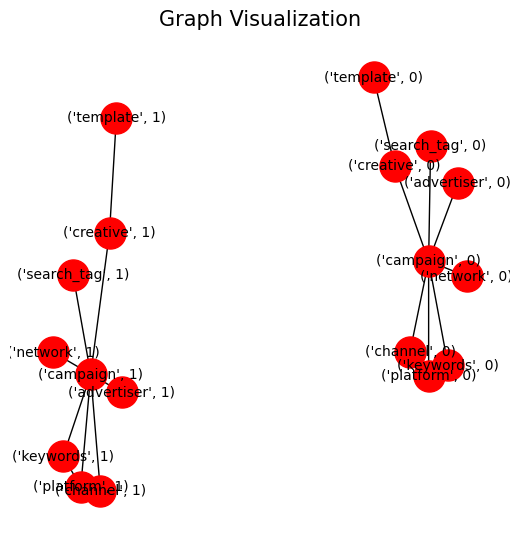

In [210]:
import matplotlib.pyplot as plt
import networkx as nx
import torch

def visualize_graph(data):
    # Create a new graph using NetworkX
    G = nx.Graph()

    # Add nodes and edges to the graph
    for edge_type, edge_index in data.edge_index_dict.items():
        src_type, _, dst_type = edge_type  # Extract source and destination node types
        for src, dst in edge_index.t().tolist():  # Add edges to the graph
            # Add nodes as (node_type, node_id)
            G.add_node((src_type, src))
            G.add_node((dst_type, dst))
            G.add_edge((src_type, src), (dst_type, dst))
    
    # Position nodes using the spring layout (force-directed layout)
    pos = nx.spring_layout(G)

    # Draw the graph
    plt.figure(figsize=(5, 5))
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='red', font_size=10)
    plt.title("Graph Visualization", fontsize=15)
    plt.show()

# Visualize the graph
visualize_graph(data)


In [211]:
from torch_geometric.utils import is_undirected, contains_self_loops
from torch.optim.lr_scheduler import StepLR


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Define the Heterogeneous GCN model
class HeteroGCN(torch.nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()

        # Define HeteroConv layer with SAGEConv for each relation
        self.conv1 = HeteroConv({
            ('campaign', 'hosted_on', 'platform'): SAGEConv((-1, -1), hidden_dim),
            ('platform', 'rev_hosted_on', 'campaign'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'uses','channel'): SAGEConv((-1, -1), hidden_dim),
            ('channel', 'rev_uses', 'campaign'): SAGEConv((-1, -1), hidden_dim),
            ('platform', 'supports', 'channel'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'uses', 'creative'): SAGEConv((-1, -1), hidden_dim),
            ('creative', 'designed_with','template'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'associated_with', 'keywords'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'managed_by', 'network'): SAGEConv((-1, -1), hidden_dim),
            ('platform', 'optimized_for', 'keywords'): SAGEConv((-1, -1), hidden_dim),
            ('campaign','belongs_to','advertiser'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'targeted_with', 'search_tag'): SAGEConv((-1, -1), hidden_dim),
            ('search_tag', 'rev_targeted_with', 'campaign'): SAGEConv((-1, -1), hidden_dim)
        }, aggr="mean")

        self.conv2 = HeteroConv({
            ('campaign', 'hosted_on', 'platform'): SAGEConv((-1, -1), hidden_dim),
            ('platform', 'rev_hosted_on', 'campaign'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'uses','channel'): SAGEConv((-1, -1), hidden_dim),
            ('channel', 'rev_uses', 'campaign'): SAGEConv((-1, -1), hidden_dim),
            ('platform', 'supports', 'channel'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'uses', 'creative'): SAGEConv((-1, -1), hidden_dim),
            ('creative', 'designed_with','template'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'associated_with', 'keywords'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'managed_by', 'network'): SAGEConv((-1, -1), hidden_dim),
            ('platform', 'optimized_for', 'keywords'): SAGEConv((-1, -1), hidden_dim),
            ('campaign','belongs_to','advertiser'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'targeted_with', 'search_tag'): SAGEConv((-1, -1), hidden_dim),
            ('search_tag', 'rev_targeted_with', 'campaign'): SAGEConv((-1, -1), hidden_dim)
        }, aggr="mean")

        self.conv3 = HeteroConv({
            ('campaign', 'hosted_on', 'platform'): SAGEConv((-1, -1), hidden_dim),
            ('platform', 'rev_hosted_on', 'campaign'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'uses','channel'): SAGEConv((-1, -1), hidden_dim),
            ('channel', 'rev_uses', 'campaign'): SAGEConv((-1, -1), hidden_dim),
            ('platform', 'supports', 'channel'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'uses', 'creative'): SAGEConv((-1, -1), hidden_dim),
            ('creative', 'designed_with','template'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'associated_with', 'keywords'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'managed_by', 'network'): SAGEConv((-1, -1), hidden_dim),
            ('platform', 'optimized_for', 'keywords'): SAGEConv((-1, -1), hidden_dim),
            ('campaign','belongs_to','advertiser'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'targeted_with', 'search_tag'): SAGEConv((-1, -1), hidden_dim),
            ('search_tag', 'rev_targeted_with', 'campaign'): SAGEConv((-1, -1), hidden_dim)
        }, aggr="mean")

        # 🔹 Add LayerNorm for stability
        self.norm1 = torch.nn.LayerNorm(hidden_dim)
        self.norm2 = torch.nn.LayerNorm(hidden_dim)
        self.norm3 = torch.nn.LayerNorm(hidden_dim)

        # Fully connected layer to produce a single output (click value)
        self.fc = torch.nn.Linear(hidden_dim * 7, 1)  # Concatenating features from 6 node types

        

    def forward(self, x_dict, edge_index_dict):

        # 🔹 Apply first convolution
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {key: self.norm1(x) for key, x in x_dict.items()}  # 🔹 Normalize
        x_dict = {key: F.leaky_relu(x, negative_slope=0.01) for key, x in x_dict.items()}

        # 🔹 Apply second convolution
        x_dict = self.conv2(x_dict, edge_index_dict)
        x_dict = {key: self.norm2(x) for key, x in x_dict.items()}  # 🔹 Normalize
        x_dict = {key: F.leaky_relu(x, negative_slope=0.01) for key, x in x_dict.items()}

        #🔹 Apply third convolution
        x_dict = self.conv3(x_dict, edge_index_dict)
        x_dict = {key: self.norm3(x) for key, x in x_dict.items()}  # 🔹 Normalize
        
        # Concatenate the features of campaign, platform, and channel for each record
        x_combined = torch.cat([x_dict['campaign'], x_dict['platform'],
                                x_dict['channel'], x_dict['creative'], x_dict['keywords'], 
                                x_dict['search_tag'], x_dict['advertiser']], dim=1)
        
        # Pass through the fully connected layer to get the single click prediction
        out = self.fc(x_combined)
        
        return out


In [212]:
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split

# Get indices for campaigns (assuming 'campaign' nodes are being predicted)
campaign_indices = torch.arange(data.x_dict['campaign'].size(0))

# 80% Train, 20% Test Split
train_idx, test_idx = train_test_split(campaign_indices.cpu().numpy(), test_size=0.2, random_state=42)

# Convert to tensors
train_idx = torch.tensor(train_idx, dtype=torch.long, device=device)
test_idx = torch.tensor(test_idx, dtype=torch.long, device=device)

In [213]:

# Initialize model
model = HeteroGCN(hidden_dim=32)
print(model)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)  # Reduce LR by 50% every 50 epochs



num_epochs = 80
best_mse = float('inf')
patience = 50
counter = 0

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass on training data (only train nodes)
    out = model(data.x_dict, data.edge_index_dict)
    train_loss = F.mse_loss(out.squeeze()[train_idx], click_values[train_idx])

    train_loss.backward()
    optimizer.step()

    train_losses.append(train_loss.item())

    # 🔹 Evaluate on test data
    model.eval()
    with torch.no_grad():
        test_out = model(data.x_dict, data.edge_index_dict)  # No need for a separate test_data
        test_loss = F.mse_loss(test_out.squeeze()[test_idx], click_values[test_idx])

    test_losses.append(test_loss.item())

    print(f"Epoch {epoch}, Train MSE: {train_loss.item():.4f}, Test MSE: {test_loss.item():.4f}")


HeteroGCN(
  (conv1): HeteroConv(num_relations=13)
  (conv2): HeteroConv(num_relations=13)
  (conv3): HeteroConv(num_relations=13)
  (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (norm3): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=224, out_features=1, bias=True)
)
Epoch 0, Train MSE: 1.9466, Test MSE: 1.0438
Epoch 1, Train MSE: 1.0584, Test MSE: 1.2063
Epoch 2, Train MSE: 1.2166, Test MSE: 1.4184
Epoch 3, Train MSE: 1.4272, Test MSE: 1.3254
Epoch 4, Train MSE: 1.3347, Test MSE: 1.1291
Epoch 5, Train MSE: 1.1399, Test MSE: 1.0107
Epoch 6, Train MSE: 1.0236, Test MSE: 1.0217
Epoch 7, Train MSE: 1.0367, Test MSE: 1.1007
Epoch 8, Train MSE: 1.1174, Test MSE: 1.1520
Epoch 9, Train MSE: 1.1695, Test MSE: 1.1366
Epoch 10, Train MSE: 1.1540, Test MSE: 1.0764
Epoch 11, Train MSE: 1.0930, Test MSE: 1.0168
Epoch 12, Train MSE: 1.0323, Test MSE: 0.9913
Epoch 13, Train MSE: 1.0055,

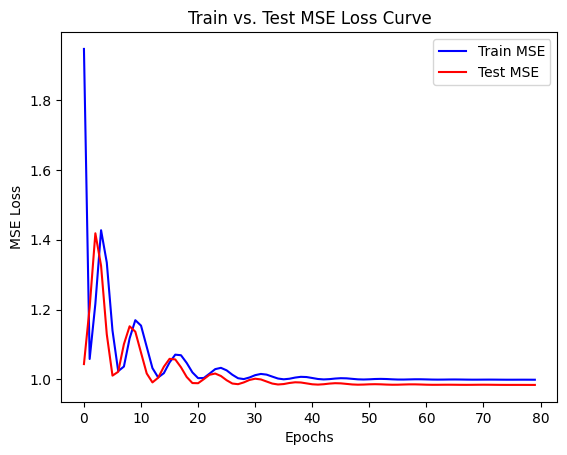

In [214]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_losses)), train_losses, label="Train MSE", color='blue')
plt.plot(range(len(test_losses)), test_losses, label="Test MSE", color='red')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Train vs. Test MSE Loss Curve")
plt.show()


In [215]:
import torch.nn.functional as F

def evaluate_model(model, data, click_values, device='cpu'):
    model.eval()  # Set the model to evaluation mode
    
    with torch.no_grad():  # Disable gradient calculation during evaluation
        # Move data to the correct device
        data = data.to(device)
        click_values = click_values.to(device)
        # Forward pass
        out = model(data.x_dict, data.edge_index_dict)
        # Ensure shapes match
        out = out[test_idx]
        click_values = click_values[test_idx]
        # Compute MSE loss between predictions and actual click values
        mse = F.mse_loss(out, click_values)  
        return mse.item()
    
# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Evaluate the model
mse_score = evaluate_model(model, data, click_values, device)
print(f"Test MSE: {mse_score:.4f}")


C:\Users\Thinkpad\AppData\Local\Temp\ipykernel_2672\1769999257.py:16: UserWarning: Using a target size (torch.Size([13150])) that is different to the input size (torch.Size([13150, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = F.mse_loss(out, click_values)


Test MSE: 0.9910


In [216]:
import torch
import torch.nn.functional as F

def r_squared(y_true, y_pred):
    """Calculate the R² (coefficient of determination) score."""
    # Move tensors to CPU and convert to numpy arrays
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()
    
    # Compute the total sum of squares and residual sum of squares
    ss_tot = ((y_true - y_true.mean()) ** 2).sum()
    ss_res = ((y_true - y_pred) ** 2).sum()
    
    # Return R² score with safeguard against division by zero
    return 1 - (ss_res / (ss_tot + 1e-8))

# Ensure the model is in evaluation mode
model.eval()

# Move model and data to the appropriate device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
data = data.to(device)
click_values = click_values.to(device)

with torch.no_grad():
    # Forward pass on the full dataset
    predictions = model(data.x_dict, data.edge_index_dict).view(-1)
    y_true = click_values.view(-1)
    
    # Apply test indices to avoid data leakage
    predictions = predictions[test_idx]
    y_true = y_true[test_idx]

    # Optional: Check for shape consistency
    assert predictions.shape == y_true.shape, f"Shape mismatch: {predictions.shape} vs {y_true.shape}"

    

# Compute R² score
r2_score = r_squared(y_true, predictions)
print(f"Test R²: {r2_score:.4f}")


Test R²: 0.0035


In [217]:
model.eval()
with torch.no_grad():
    predictions = model(data.x_dict, data.edge_index_dict).squeeze()[test_idx]

print("Actual vs Predicted Clicks:")
for actual, predicted in zip(click_values[test_idx][:10].tolist(), predictions[:10].tolist()):
    print(f"Actual: {actual:.4f}, Predicted: {predicted:.4f}")


Actual vs Predicted Clicks:
Actual: -0.5334, Predicted: 0.0224
Actual: -0.0264, Predicted: -0.2080
Actual: -0.4771, Predicted: 0.0005
Actual: -0.3644, Predicted: 0.0314
Actual: -0.4208, Predicted: 0.0141
Actual: -0.5898, Predicted: 0.0654
Actual: -0.5334, Predicted: 0.0131
Actual: 3.5789, Predicted: 0.0158
Actual: 0.0299, Predicted: 0.0396
Actual: -0.4771, Predicted: -0.1474


In [218]:
# Run model inference
model.eval()
with torch.no_grad():
    output = model(data.x_dict, data.edge_index_dict)
    print("Shape of output:", output.shape)


new_campaign_pred = output[-1]  # Assuming last row corresponds to the new campaign
print("Predicted clicks for new campaign:", new_campaign_pred.item())


Shape of output: torch.Size([65749, 1])
Predicted clicks for new campaign: 0.04181481525301933


In [219]:
print("First 10 predictions:\n", output[:10])
print("Output shape:", output.shape)
print("Number of campaign nodes:", len(data.x_dict['campaign']))


First 10 predictions:
 tensor([[-0.2480],
        [ 1.7839],
        [-0.1206],
        [-0.0785],
        [-0.1186],
        [-0.1516],
        [-0.1342],
        [-0.0995],
        [-0.1455],
        [-0.1304]])
Output shape: torch.Size([65749, 1])
Number of campaign nodes: 65749


In [220]:
print("Last campaign features in dataset:", data.x_dict['campaign'][-1])
print("New campaign features:", new_campaign_features)  # Replace with actual feature tensor


Last campaign features in dataset: tensor([1.4000e+02, 5.0847e-02])


NameError: name 'new_campaign_features' is not defined

IndexError: too many indices for tensor of dimension 2

In [ ]:
# torch.save(model.state_dict(), "sage_model.pth")  # ✅ Save only weights
